# Test a `schema.org/Dataset` for DataONE compatibility

This script uses rdflib and pySHACL to evaluate whether a json-ld structure can be harvested by DataONE.

References:

* SHACL : https://www.w3.org/TR/shacl/
* Turtle: https://www.w3.org/TeamSubmission/turtle/
* pySHACL : https://github.com/RDFLib/pySHACL




In [35]:
import io
import rdflib
import rdflib.tools.rdf2dot
import graphviz
import pyshacl

def renderGraph(g):
    fp = io.StringIO()
    rdflib.tools.rdf2dot.rdf2dot(g, fp)
    return graphviz.Source(fp.getvalue())    


def isDataset(data_graph):
    """
    Return True if the provided data_graph is an instance of schema.org/Dataset
    """
    q = """PREFIX rdf:      <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX schema:   <http://schema.org/>

    SELECT ?x 
    WHERE { 
        ?x rdf:type schema:Dataset .
    }
    """
    qres = data_graph.query(q)
    return len(qres) >= 1


def evaluateShape(data_graph, shape_graph_file="dataset_shape.ttl"):
    shape_0 = rdflib.Graph()
    shape_0.parse(shape_graph_file, format="turtle")
    conforms, results_graph, results_text = pyshacl.validate(
        data_graph, 
        shacl_graph=shape_0, 
        inference="rdfs", 
        meta_shacl=False, 
        abort_on_error=False, 
        debug=False
    )
    return conforms, results_graph, results_text

    

Define a basic Dataset structure in json-ld:

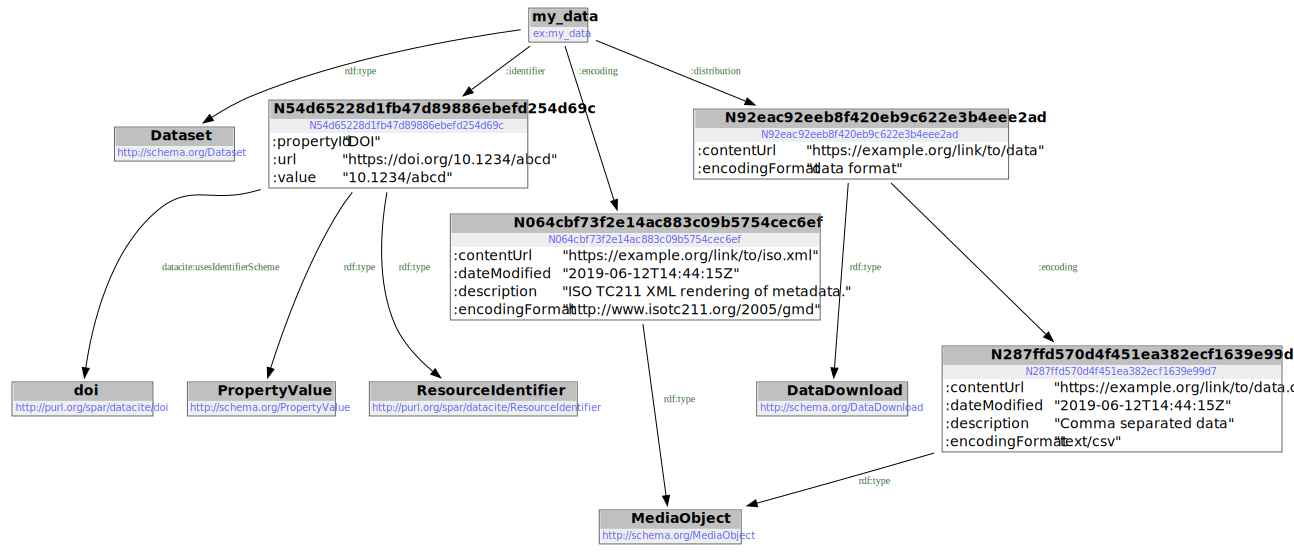

In [36]:
data00 = b"""{
    "@context":{ 
        "@vocab": "http://schema.org/",
        "datacite": "http://purl.org/spar/datacite/"
    },
    "@id":"ex:my_data",
    "@type": "Dataset",
    
    "identifier": {
        "@type": ["PropertyValue", "datacite:ResourceIdentifier"],
        "datacite:usesIdentifierScheme": { 
            "@id": "datacite:doi" 
        },
        "propertyId":"DOI",
        "url": "https://doi.org/10.1234/abcd",
        "value": "10.1234/abcd"
    },
    "encoding":{
        "@type": "MediaObject",
        "contentUrl":"https://example.org/link/to/iso.xml",
        "encodingFormat":"http://www.isotc211.org/2005/gmd",
        "description":"ISO TC211 XML rendering of metadata.",
        "dateModified":"2019-06-12T14:44:15Z"
    },
    "distribution": [
        {
            "@type":"DataDownload",
            "contentUrl": "https://example.org/link/to/data",
            "encodingFormat":"data format",
            "encoding": {
                "@type": "MediaObject",
                "contentUrl":"https://example.org/link/to/data.csv",
                "encodingFormat":"text/csv",
                "description":"Comma separated data",
                "dateModified":"2019-06-12T14:44:15Z"            
            }
        }
    ]
}
"""
data00_graph = rdflib.Graph()
data00_graph.parse(io.BytesIO(data00), format="json-ld")
gv = renderGraph(data00_graph)
gv

Verify that the data graph contains a Dataset instance:

In [37]:
print(f"The data graph contains a Dataset: {isDataset(data00_graph)}")

The data graph contains a Dataset: True


Evaluate the loaded graph against a Dataset SHACL shape.

In [38]:
conforms, results_graph, results_text = evaluateShape(data00_graph)

print(f"The data graph is of the required shape: {conforms}")
if not conforms:
    print(results_text)


The data graph is of the required shape: True


Evaluate a data graph that does not comply because it does not have an identifier:

In [43]:
data01 = b"""{
    "@context":{ 
        "@vocab": "http://schema.org/",
        "datacite": "http://purl.org/spar/datacite/"
    },
    "@id":"ex:my_data",
    "@type": "Dataset",
    
    "encoding":{
        "@type": "MediaObject",
        "contentUrl":"https://example.org/link/to/iso.xml",
        "encodingFormat":"http://www.isotc211.org/2005/gmd",
        "description":"ISO TC211 XML rendering of metadata.",
        "dateModified":"2019-06-12T14:44:15Z"
    },
    "distribution": [
        {
            "@type":"DataDownload",
            "contentUrl": "https://example.org/link/to/data",
            "encodingFormat":"data format"
        }
    ]
}
"""
data01_graph = rdflib.Graph()
data01_graph.parse(io.BytesIO(data01), format="json-ld")
print(f"The data graph contains a Dataset: {isDataset(data01_graph)}")
conforms, results_graph, results_text = evaluateShape(data01_graph)
print(f"The data graph is of the required shape: {conforms}")
if not conforms:
    print()
    print(results_text)


The data graph contains a Dataset: True
The data graph is of the required shape: False

Validation Report
Conforms: False
Results (2):
Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:message Literal("A dataset must have an identifier. All components of the dataset must be discoverable when resolving the identifier", lang=en) ; sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:identifier ]
	Focus Node: <ex:my_data>
	Result Path: schema:identifier
	Message: A dataset must have an identifier. All components of the dataset must be discoverable when resolving the identifier
Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:class schema:MediaObject ; sh:message Literal("A MediaObject is required in order to identify the location of the XML encoding of the metadata.", lang